#                                   Description Triangle Algorithm                                   #
                                        
####################### each crownstone #######################                           

1a: Check all connections in area in certain range of RSSI \
1b: Communicate with neighbours, request RSSI and update the vertices in the formed array/table \
#-------------------> Array format: cX/cY/RSSI \

2: sort the list of vertices. at the top his own vertices in order of RSSI value \
3: start at the top of the list, take a = list(i) and b = list(i+1) / two best connections, for example: c1/c2/-45 and c1/c3/-47 \
4a: send message to both Crownstones, in this example c2 and c3, to ask for their vertices / specific vertices between two known crownstones \
4b If there is a node/vertice match, make a triangle with pointers to the vertices array/table \
#-------------------> Array format: p1/p2/p3 \
5: If not, take b = list(i++), maximum check = 5?, still not found? discard, a = list(i++), and continue at #3: \

####################### Communication ####################### 
                                        
Between two Crownstones: \
1: Request: check his connections on a specific Crownstone \
<->  \
2: Answer: specific Crownstone connection values in format: cX(already known)/cY/RSSI \

Mesh message between all Crownstones:\ 
1: Global request for exchange of triangles to Hub \
2: Every Cronwstone sends its best triangles (max 3-5) \

####################### Processing/Mapping ####################### 

All triangles will be send to the hub. The hub will further process the triangles to a map.


In [5]:
# Run once to install all packages needed
# %pip install ipympl, matplotlib, networkx, pandas, numpy 

In [6]:
%matplotlib widget

import random
from random import normalvariate
import math
from math import sqrt, log10
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import networkx as nx
from IPython.display import display, clear_output
import ipywidgets as widgets
from collections import Counter

random.seed(7)

office_width = 10
office_height = 10
num_nodes = 3
noise_level = 20

In [7]:
def compareGraph2D(CheckEdge_List):
    G = nx.Graph()
    for edge in CheckEdge_List:
        if edge.src not in G.nodes():
            G.add_node(edge.src.uuid, pos=edge.src.coord[:2])
        G.add_edge(edge.src.uuid, edge.dst.uuid, Rssi=edge.rssi)

    pos = nx.get_node_attributes(G, 'pos')
    rssi = nx.get_edge_attributes(G, "Rssi")

    plt.figure(figsize=(12, 12))

    # Draw finer grid
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

    # Draw nodes as scatter plot and text labels
    for nodeID, coords in pos.items():
        plt.scatter(*coords, c="blue", s=100, marker='o')
        plt.text(*coords, f'Node {nodeID}\n({coords[0]}, {coords[1]})', ha='center', va='bottom')

    # Draw edges in 3D
    for edge in G.edges():
        xs, ys = zip(*[pos[edge[i]] for i in range(2)])
        plt.plot(xs, ys, color='black')
        rssi_value = rssi.get(edge, "")
        plt.text(sum(xs)/2,sum(ys)/2, f"{rssi_value}", color='red')

    plt.title("Node plot with signal strength (RSSI)")
    plt.grid()
    plt.show()


def compareGraph3D(CheckEdge_List):
    G = nx.Graph()
    for edge in CheckEdge_List:
        if edge.src not in G.nodes():
            G.add_node(edge.src.uuid, pos=edge.src.coord)
        G.add_edge(edge.src.uuid, edge.dst.uuid, Rssi=edge.rssi)

    pos = nx.get_node_attributes(G, 'pos')
    rssi = nx.get_edge_attributes(G, "Rssi")

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')  # Create a 3D axis

    # Draw nodes as scatter plot and text labels
    for nodeID, coords in pos.items():
        ax.scatter(*coords, c="blue", s=100, marker='o')
        ax.text(*coords, f'Node {nodeID}\n({coords[0]}, {coords[1]}, {coords[2]})', ha='center', va='bottom')

    # Draw edges in 3D
    for edge in G.edges():
        xs, ys, zs = zip(*[pos[edge[i]] for i in range(2)])
        ax.plot(xs, ys, zs, color='black')
        rssi_value = rssi.get(edge, "")
        ax.text(sum(xs)/2,sum(ys)/2,sum(zs)/2, f"{rssi_value}", color='red')

    ax.set_title("Node plot with signal strength (RSSI) (3D)")
    plt.show()

def printNice(table):
    for i, item in enumerate(table):
        print(item)

def distance_to_rssi(node1, node2):
    c1x, c1y, c1z = node1.coord
    c2x, c2y, c2z = node2.coord
    distance = math.sqrt((c1x-c2x)**2 + (c1y-c2y)**2 + (c1z-c2z)**2)
    # noise = normalvariate(0, sqrt(noise_level))
    noise = 0
    rssi = -70 - 10 * 2.0 * log10(distance) + noise
    # return round(distance, 3)
    return round(rssi, 3)


# log function or later try neural net conversion
def rssi_to_distance(rssi):
    return round(10**((-rssi-70)/(20)),3)

In [8]:
class Node:

    def __init__(self, node_id: int, x: float, y: float, z: float):
        self.uuid = node_id
        self.coord = (x,y,z)
        self.edgeList = []
        self.triangleList = []

    def __str__(self) -> str:
        return f"Node (Uuid= {self.uuid}, Coord= {self.coord})"
    
    def resetNode(self):
        self.coord = (None,None,None)


class Edge:

    def __init__(self, src: Node, dst: Node, rssi):
        self.edgeID = (src.uuid,dst.uuid)
        self.src = src
        self.dst = dst
        self.rssi = rssi
        self.dist = rssi_to_distance(self.rssi)

    def __str__(self) -> str:
        return f"({self.src.uuid},{self.dst.uuid},{self.dist:.3f})"
    
    def __hash__(self) -> int:
        return hash((self.src,self.dst,self.rssi))
    
    # check exactly the same
    def __eq__(self, other: object) -> bool:
        return self.__hash__() == other.__hash__()

    # check if it is the same edge on uuid, can be improved
    def edgeCompare(self, other: object):

        self_src_uuid, self_dst_uuid = int(self.src.uuid), int(self.dst.uuid)
        other_src_uuid, other_dst_uuid = int(other.src.uuid), int(other.dst.uuid)

        # Check if both edges have the same UUIDs
        return (
            (self_src_uuid == other_src_uuid and self_dst_uuid == other_dst_uuid) or
            (self_src_uuid == other_dst_uuid and self_dst_uuid == other_src_uuid)
        )
    
    # Create a new Edge with the source and destination nodes reversed
    def reverseEdge(self):
        return Edge(self.dst, self.src, self.rssi)



class Triangle:

    def __init__(self, edge1: Edge, edge2: Edge, edge3: Edge):
        self.edgeList = [edge1,edge2,edge3]
        self.weight = round(sum(edge.rssi for edge in self.edgeList), 3)
        self.nodeSet = set([edge1.src.uuid, edge1.dst.uuid, edge2.src.uuid, edge2.dst.uuid, edge3.src.uuid, edge3.dst.uuid])

    def __str__(self) -> str:
        edges_str = ', '.join(map(str, self.edgeList))
        return f"Triangle {id(self)}: Weight= {self.weight:.3f}, Edges= {edges_str}, Nodes= {self.nodeSet}"
    
    def __hash__(self) -> int:
        return hash(self.weight)
    
    # def reorderTriangle(self, baseEdge: Edge, edge1, edge2):
    #     self.edgeList[0] = baseEdge
    #     self.edgeList[1] = edge1
    #     self.edgeList[2] = edge2
    
    def reverseTriangle(self):
        return Triangle(self.edgeList[0].reverseEdge(),self.edgeList[2].reverseEdge(),self.edgeList[1].reverseEdge())
    
    def __eq__(self, other: object) -> bool:
        return set(self.edgeList) == set(other.edgeList)
    
    def hasEdge(self, edge_to_check: Edge) -> bool:
        for edge in self.edgeList:
            if edge == edge_to_check or edge == Edge(edge.dst,edge.src,edge.rssi):
                return True
        return False
    
    def getOtherEdges(self, edge_to_check: Edge) -> list:
        returnlist = list()
        for edge in self.edgeList:
            if edge != edge_to_check: #  or edge != Edge(edge.dst,edge.src,edge.rssi):
                returnlist.append(edge)
        return returnlist
    
    def getLastNodeID(self, edge_to_check: Edge) -> int:
        for edge in self.edgeList:
            for e in edge.edgeID:
                if e != edge_to_check.edgeID[0] and e != edge_to_check.edgeID[1]:
                    return e
                
    def getEdgeIndex(self, edge_to_check: Edge) -> int:
        for i, edge in enumerate(self.edgeList):
            if edge.edgeCompare(edge_to_check):
                return i
            
    def getAngles(self, base_edge: Edge):
        base = self.getEdgeIndex(base_edge)
        a = self.edgeList[(base+2)%3].dist # 
        b = self.edgeList[(base+0)%3].dist # 
        c = self.edgeList[(base+1)%3].dist # 
        ha = round(np.rad2deg(np.arccos((c**2+b**2-a**2)/(2*c*b))),3)
        hb = round(np.rad2deg(np.arccos((a**2+c**2-b**2)/(2*a*c))),3)
        hc = round(np.rad2deg(np.arccos((a**2+b**2-c**2)/(2*a*b))),3)
        return (ha,hb,hc)

    """
        Returns the Altitude H of the Triangle from base edge perspective
    """              
    def getAltitudeLength(self, base_edge: Edge): # a--b--c, base = 0,1,2
        base = self.getEdgeIndex(base_edge)
        a = self.edgeList[(base+2)%3].dist # 
        b = self.edgeList[(base+0)%3].dist # 
        c = self.edgeList[(base+1)%3].dist # 
        # Heron's formula 
        s = (a+b+c)/2
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        h = (2*area)/b
        return h
    
    """
        Returns the distance x from perpective of the base edge source node
    """
    def getAltitudeX(self, base_edge: Edge): # p | q = c
        base = self.getEdgeIndex(base_edge)
        # print(f'{self.edgeList[(base+0)%3]}<->{self.edgeList[(base+1)%3]}<->{self.edgeList[(base+2)%3]}')
        a = self.edgeList[(base+2)%3].dist
        b = self.edgeList[(base+0)%3].dist
        c = self.edgeList[(base+1)%3].dist 
        # Pythagoras formula
        x = (b**2 + c**2 - a**2) / (2 * b)
        return x
    

class AdjTriangles:

    def __init__(self, theEdge: Edge, adjTriangle_list: list):
        self.theEdge = theEdge
        self.adjTriangles = adjTriangle_list
        self.counter = 0
        self.AdjAltiH = []
        self.AdjAltiX = []
        self.angles = []
        self.getAdjAltitude(theEdge)

    def __str__(self) -> str:
        adjTriangles_str = '\n'.join(map(str, self.adjTriangles))
        adjAltiH_str = ', '.join(map(str, self.AdjAltiH))
        adjAltiX_str = ', '.join(map(str, self.AdjAltiX))
        angle_str  = ', '.join(map(str, self.angles))
        return f"Edge{self.theEdge} ID={id(self)}: Adjacent Triangles({len(self.adjTriangles)})=\n{adjTriangles_str}\n Adjacent altitudes: {adjAltiH_str}, X coords: {adjAltiX_str} and angles: {angle_str}"
    
    def getAdjacent(self) -> Triangle:
        if len(self.adjTriangles) < 1:
            print("No triangles")
            return None
        elif self.counter < len(self.adjTriangles):
            temp = self.adjTriangles[self.counter] 
            self.counter += 1        
            return temp
        else:
            print("All triangles are already placed!")
            return None
        
    def getAllAdjacent(self) -> Triangle:
        if len(self.adjTriangles) < 1:
            print("No triangles")
            return None
        else:
            return self.adjTriangles
        
    def resetCounter(self):
        self.counter = 0

    def getAdjAltitude(self, base_edge: Edge):
        for adj in self.getAllAdjacent():
            self.AdjAltiH.append(adj.getAltitudeLength(base_edge))
            self.AdjAltiX.append(adj.getAltitudeX(base_edge))
            self.angles.append(adj.getAngles(base_edge))

    def checkEdgeInverse(self, other: object):
        for i, H in enumerate(self.AdjAltiH):
            print(f'check: {H} with {other.AdjAltiH[i]}')
            if H != other.AdjAltiH[i]:
                return False
        for i, X in enumerate(self.AdjAltiX):
            print(f'check: {X} with {(self.theEdge.dist - other.AdjAltiX[i])}')
            if X != (self.theEdge.dist - other.AdjAltiX[i]):
                return False
        return True

List of nodes:
Node (Uuid= 0, Coord= (3.0, 1.5, 2.0))
Node (Uuid= 1, Coord= (0.5, 5.5, 1.0))
Node (Uuid= 2, Coord= (0.5, 5.0, 0.0))

List of Edges:
(0,2,4.744)
(0,1,4.822)
(1,2,1.118)
(1,0,4.822)
(2,1,1.118)
(2,0,4.744)



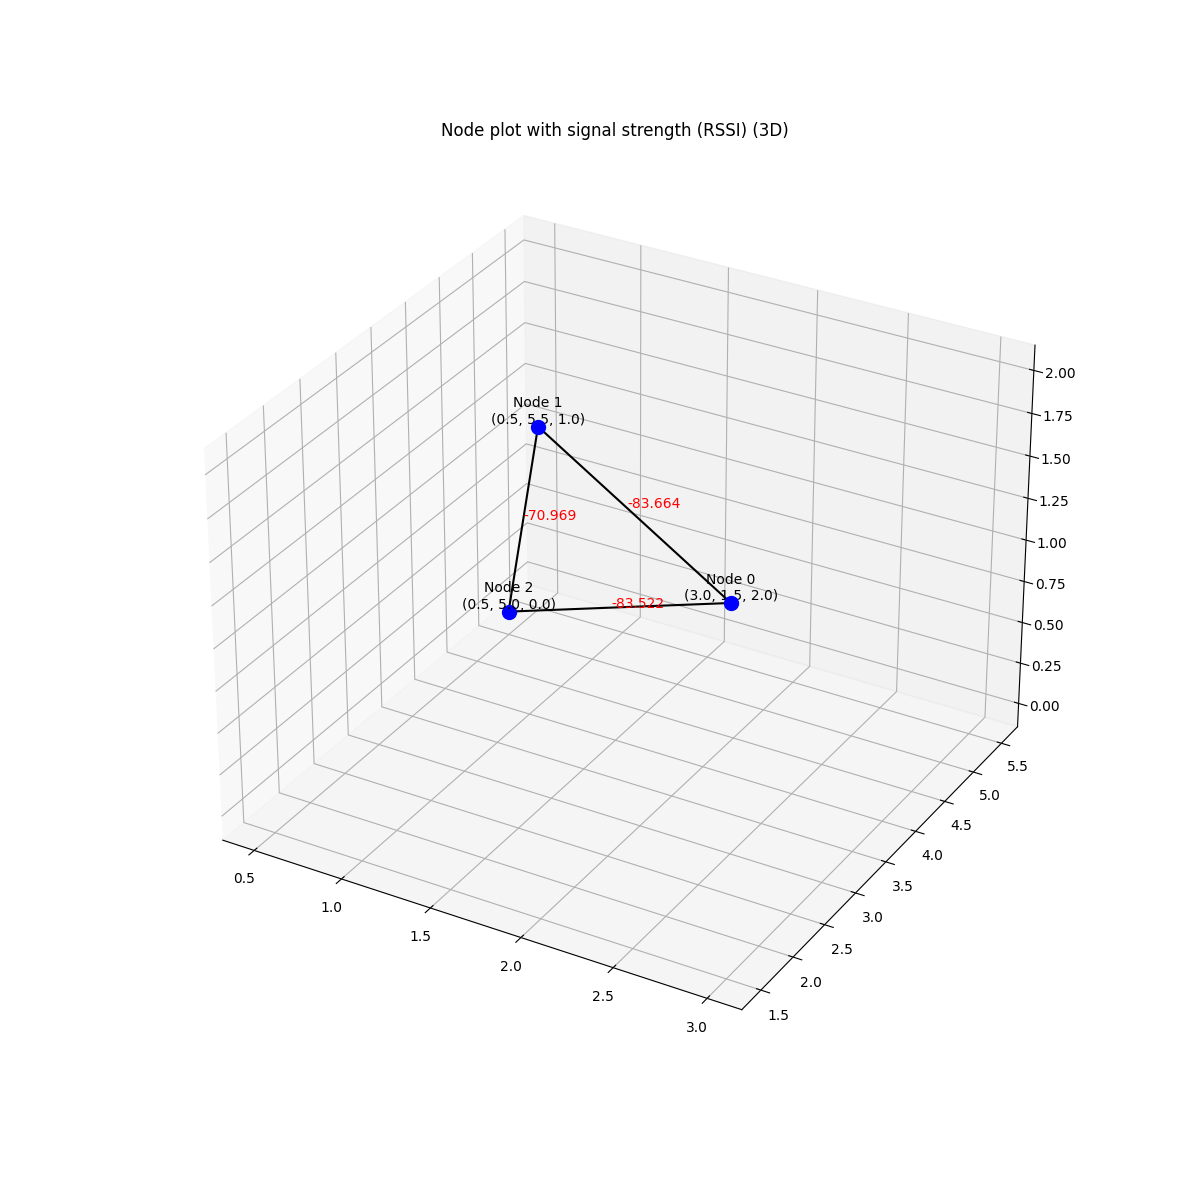

In [9]:
nodeList = []
Check = set()
index = 0 

while len(nodeList) < num_nodes:
    x = round(random.uniform(0, office_width) * 2) / 2
    y = round(random.uniform(0, office_height) * 2) / 2
    z = round(random.uniform(0, 3) * 2) / 2
    
    if (x, y, z) not in Check:
        Check.add((x, y, z))
        nodeList.append(Node(index, x, y, z))
        index += 1

print("List of nodes:")
printNice(nodeList)
print()

CheckEdgeList = []
for i in range(len(nodeList)):
    table = []
    for j in range(len(nodeList)):
        if nodeList[i] != nodeList[j]:
            table.append(Edge(nodeList[i], nodeList[j], distance_to_rssi(nodeList[i], nodeList[j])))

    table = sorted(table, key=lambda x: x.rssi, reverse=True)
    CheckEdgeList.append(table)

CheckEdgeList = [item for table in CheckEdgeList for item in table]

print("List of Edges:")
for edge in CheckEdgeList:
    print(edge)
print()

# pre-process taking the mean rssi of two same connections
# preprocRssi(check_data)

# plot
compareGraph3D(CheckEdgeList)

<h1> Part 1: Edges --> Triangles </h1>

In [10]:
def makeEdgeDict(edge_list):
    edges_dict = {}
    for edge in edge_list:
        if edge.src not in edges_dict:
            edges_dict[edge.src] = []
        edges_dict[edge.src].append(edge)
    return edges_dict

In [11]:
# finding best n triangles with highest total weight, for global list

def findingBestNtriangles(edge_list, n):
    triangle_dict = {}
    edge_dict = makeEdgeDict(edge_list).items()
    for start_node, node_edge_list in edge_dict:
        triangle_dict[start_node] = []
        CheckWeight = set()
        for edge1 in node_edge_list:
            for edge2 in node_edge_list:
                if edge1.dst != edge2.dst:
                    for edge3 in edge_list:
                        if edge3.src == edge2.dst and edge3.dst == edge1.dst:
                            tempTriangle = Triangle(edge1,edge2,edge3)
                            if tempTriangle.weight not in CheckWeight:
                                triangle_dict[start_node].append(tempTriangle)
                                CheckWeight.add(tempTriangle.weight)

        # Keep the top 3 triangles based on weight
        triangle_dict[start_node] = sorted(triangle_dict[start_node], key = lambda x: x.weight, reverse=True)
        triangle_dict[start_node] = triangle_dict[start_node][:n]

    return triangle_dict

In [12]:
# Print the triangles for each node
def printTriangles(triangles_dict):
    listoftriangles = []
    for start_node, triangle_list in triangles_dict.items():
        print(f"Triangles of {start_node}:")
        for i, triangle in enumerate(triangle_list, 1):
            print(triangle)
            listoftriangles.append(triangle)
        print()
    return listoftriangles


In [13]:
def plotTriangles(triangles_List):
    colors = plt.cm.hsv
    fig, ax = plt.subplots(figsize=(8, 6))

    for i, triangle in enumerate(triangles_List):
        color = colors(i / len(triangles_List))
        for edge in triangle.edgeList:
            x_coords = [float(edge.src.uuid), float(edge.dst.uuid)]
            y_coords = [i for _ in range(2)]
            ax.plot(x_coords, y_coords, color=color, marker='o')

    ax.set_xlabel("Node IDs")
    ax.set_ylabel("Triangle")
    ax.set_title("Triangles Plot")

    ax.set_xticks(range(0, num_nodes, 1))
    ax.set_yticks(range(len(triangles_List)))
    ax.set_yticklabels(['Triangle {}'.format(i+1) for i in range(len(triangles_List))])

    ax.grid()
    plt.tight_layout()
    plt.show()

Triangles of Node (Uuid= 0, Coord= (3.0, 1.5, 2.0)):
Triangle 1553119483088: Weight= -238.155, Edges= (0,2,4.744), (0,1,4.822), (1,2,1.118), Nodes= {0, 1, 2}

Triangles of Node (Uuid= 1, Coord= (0.5, 5.5, 1.0)):
Triangle 1553133501008: Weight= -238.155, Edges= (1,2,1.118), (1,0,4.822), (0,2,4.744), Nodes= {0, 1, 2}

Triangles of Node (Uuid= 2, Coord= (0.5, 5.0, 0.0)):
Triangle 1553084401744: Weight= -238.155, Edges= (2,1,1.118), (2,0,4.744), (0,1,4.822), Nodes= {0, 1, 2}



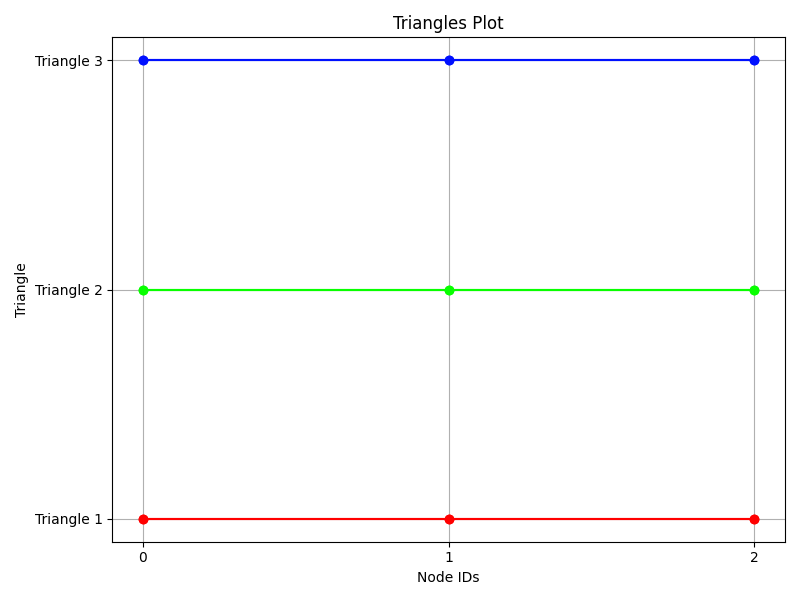

True
Triangle 1553119483088: Weight= -238.155, Edges= (0,2,4.744), (0,1,4.822), (1,2,1.118), Nodes= {0, 1, 2}
(13.391, 79.331, 87.278)


In [14]:
# from edge data, each node makes a list of its n best connected triangles
amountOftriangles = 3

trianglePerNode = findingBestNtriangles(CheckEdgeList, amountOftriangles)

trianglesList = printTriangles(trianglePerNode)

plotTriangles(trianglesList)

print(trianglesList[0].__eq__(trianglesList[0]))

print(trianglesList[0])
print(trianglesList[0].getAngles(trianglesList[0].edgeList[0]))

In [15]:
print(CheckEdgeList[4])
print(trianglesList[0])
print(trianglesList[0].hasEdge(CheckEdgeList[1])) # dst src swapped

(2,1,1.118)
Triangle 1553119483088: Weight= -238.155, Edges= (0,2,4.744), (0,1,4.822), (1,2,1.118), Nodes= {0, 1, 2}
True


<h1> Part 2: Triangles --> Map </h1>

**Algorithm Steps:**

1. **Initialization:**
   - Create a dictionary to store node positions, initialize with (None,None)
   - Search for the most connected node and place this node at (0, 0)
   - Optional: convert RSSI to distance for all triangle edges; with path los model formula or Neural Net
   - Transform triangle data into 'TrianglesPerEdge' dataset

2. **Triangle-Based Positioning Iteration:**
   - Iterate through the set of placed nodes (which starts with the BestNode):
     - Get best edge X and place it. 
     - Get best triangle that includes edge X
     - Place the third node of the triangle with trilateration on the distance/rssi

3. **Triangle-Based Positioning Iteration:**
   - Iterate the placed edges
      - Work through the list of triangles that include this edge
      - Place the third node of the triangle with trilateration on the distance/rssi

4. **Repeat Steps 3:**
   - Continue iterating through triangles and edges multiple times, allowing the positions to refine gradually based on connectivity and distance constraints.


5. **Convergence Criteria:**
   - You can set a convergence criteria, such as a maximum number of iterations or a threshold for position updates. If the algorithm reaches this criteria, it can stop iterating.


**Additional Considerations:**

- **Optimization:** Depending on the number of nodes and triangles, you might need to implement optimizations to improve the efficiency of the algorithm. Techniques like spatial partitioning (e.g., quadtree) can help reduce the number of distance calculations.

- **Handling Conflicts:** In cases where constraints are conflicting (e.g., triangle positions contradict edge distances), you might need to prioritize certain constraints over others or use heuristics to resolve conflicts.

- **Error Handling:** It's important to handle cases where the given data is inconsistent or ambiguous.

- **Visualization:** You can visualize the node positions and triangles as the algorithm progresses to observe how the layout evolves.

In [16]:
def checkTriangle(check: Triangle, triangles: list):
    for tri in triangles:
        if tri.weight == check.weight:
            return False
    return True

def findTrianglesPerEdge(triangles_List, prinT = False):
    triangle_dict = {}
    for triangle in triangles_List:
        for edge in triangle.edgeList:
            reverse_edge = edge.reverseEdge()

            if edge not in triangle_dict:
                triangle_dict[edge] = [triangle]
            else:
                if checkTriangle(triangle,triangle_dict[edge]):                            
                    triangle_dict[edge].append(triangle)

            if reverse_edge not in triangle_dict:
                triangle_dict[reverse_edge] = [triangle.reverseTriangle()]
            else:
                if checkTriangle(triangle,triangle_dict[reverse_edge]):
                    triangle_dict[reverse_edge].append(triangle.reverseTriangle())
    
    for edgeKey, triangle_list in triangle_dict.copy().items():
        if prinT:
            print(f"Triangles of {edgeKey.edgeID}:")
            for triangle in triangle_list:
                print(triangle)
            print()
        triangle_dict[edgeKey.edgeID] = AdjTriangles(edgeKey,triangle_list)
        del triangle_dict[edgeKey]

    return triangle_dict

In [17]:
def findMostConnectedNode(triangles_List) -> Node:

    # Count occurrences of vertices and edges
    node_counter = Counter()

    for edge in [edge for triangle in triangles_List for edge in triangle.edgeList]:
        node_counter.update([edge.src, edge.dst])
    
    # Find the most common vertex and edge
    most_common_vertex = node_counter.most_common(1)[0][0]

    return most_common_vertex

def findBestEdge(triangles_dict: dict, node_to_check: Node) -> Edge:
    # Count occurrences of vertices and edges
    bestEdge = triangles_dict[node_to_check][0].edgeList[0]

    for edge in [edge for triangle in triangles_dict[node_to_check] for edge in triangle.edgeList]:
        if edge.src == node_to_check and edge.dist < bestEdge.dist:
            bestEdge = edge 
    
    return bestEdge    

In [18]:
def printAllAdj(Adjacent_Dict):
    print("All edges with adjacent triangles:")
    for edgeKey, AdjObject in Adjacent_Dict.items():
        print(f"{edgeKey} => {AdjObject}")
    print()

In [19]:
def initNodes(node_list) -> dict:
   node_Coords = {}
   for node in node_list:
      node_Coords[node.uuid] = node
      node_Coords[node.uuid].resetNode()
   return node_Coords

def printCoords(node_Coords):
    for i, coords in node_Coords.items():
        print(coords)
    print()

def resetNodes(node_coords):
   for i, node in node_coords.items():
      node_coords[node.uuid].resetNode()

In [20]:
# Initialize nodes
nodeCoords = initNodes(nodeList)

# From triangles, find most connected node and place the node at (0,0, 0)
bestNode = findMostConnectedNode(trianglesList)
nodeCoords[bestNode.uuid].coord = (0,0,0) 
bestEdge = findBestEdge(trianglePerNode, bestNode)
print(f"Best edge (of bestNode {bestNode.uuid}): {bestEdge}\n")
nodeCoords[bestEdge.dst.uuid].coord = (bestEdge.dist, 0, 0)
 
print("Start coordinates for all vertices:")
printCoords(nodeCoords)

Best edge (of bestNode 0): (0,2,4.744)

Start coordinates for all vertices:
Node (Uuid= 0, Coord= (0, 0, 0))
Node (Uuid= 1, Coord= (None, None, None))
Node (Uuid= 2, Coord= (4.744, 0, 0))



In [21]:
AdjacentDict = findTrianglesPerEdge(trianglesList)
printAllAdj(AdjacentDict)

All edges with adjacent triangles:
(0, 2) => Edge(0,2,4.744) ID=1553184407056: Adjacent Triangles(1)=
Triangle 1553119483088: Weight= -238.155, Edges= (0,2,4.744), (0,1,4.822), (1,2,1.118), Nodes= {0, 1, 2}
 Adjacent altitudes: 1.1167384661999087, X coords: 4.690903878583475 and angles: (13.391, 79.331, 87.278)
(2, 0) => Edge(2,0,4.744) ID=1553184403600: Adjacent Triangles(1)=
Triangle 1553184402448: Weight= -238.155, Edges= (2,0,4.744), (2,1,1.118), (1,0,4.822), Nodes= {0, 1, 2}
 Adjacent altitudes: 1.1167384661999065, X coords: 0.053096121416525976 and angles: (87.278, 79.331, 13.391)
(0, 1) => Edge(0,1,4.822) ID=1553133682128: Adjacent Triangles(1)=
Triangle 1553119483088: Weight= -238.155, Edges= (0,2,4.744), (0,1,4.822), (1,2,1.118), Nodes= {0, 1, 2}
 Adjacent altitudes: 1.0986742604007378, X coords: 0.20697552882621337 and angles: (79.331, 87.278, 13.391)
(1, 0) => Edge(1,0,4.822) ID=1553184407120: Adjacent Triangles(1)=
Triangle 1553184401552: Weight= -238.155, Edges= (2,0,4.744

In [22]:
def circleIntersect(x1, y1, dAC, x2, y2, dBC):
    # Intersect two circles calculation
    R = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    a = (dAC**2 - dBC**2) / (2 * R**2)
    c = math.sqrt(2 * (dAC**2 + dBC**2) / R**2 - ((dAC**2 - dBC**2)**2) / R**4 -1)
    # Coordinate X
    fx = (x1 + x2) / 2 + a * (x2 - x1)
    gx = c * (y2 - y1) / 2
    # Two options
    x3a = fx + gx
    x3b = fx - gx
    # Coordinate Y
    fy = (y1 + y2) / 2 + a * (y2 - y1)
    gy = c * (x1 - x2) / 2
    # Two options
    y3a = fy + gy
    y3b = fy - gy

    print(f"{(x3a,y3a)} and {(x3b,y3b)}")
    return (x3a,y3a,0),(x3b,y3b,0)

In [23]:
# Create a function to plot a circle at position on the x-axis, in plane YZ
def plot_circle(ax, start_point, r, c):
    theta = np.linspace(0, 2 * np.pi, 300)
    x = np.full_like(theta, start_point[0])
    y = start_point[1] + r * np.cos(theta)
    z = start_point[2] + r * np.sin(theta)
    ax.plot(x, y, z, color=c)

# Function that plots a circle in 3d space; XY plane
def plotCirclePolar(ax, start_point, polar_angle_deg, r, c):
    theta = np.linspace(0, 2 * np.pi, 201)
    polar_angle_rad = np.deg2rad(polar_angle_deg)
    x = start_point[0] + r * np.cos(theta) * np.cos(polar_angle_deg)
    y = start_point[1] + r * np.sin(theta)
    z = start_point[2] + r * np.cos(theta) * np.sin(polar_angle_deg)
    ax.plot(x, y, z, color=c, label=f"{polar_angle_rad}")


def draw_circle(ax, start_point, azimuthal_angle_deg, polar_angle_deg, r, c):
    theta = np.deg2rad(polar_angle_deg)
    phi = np.deg2rad(azimuthal_angle_deg)
    t = np.linspace(0, 2 * np.pi, 201)
    x = start_point[0] - r * (np.cos(t) * np.sin(phi) + np.sin(t) * np.cos(theta) * np.cos(phi))
    y = start_point[1] + r * (np.cos(t) * np.cos(phi) - np.sin(t) * np.cos(theta) * np.sin(phi))
    z = start_point[2] + r * np.sin(t) * np.sin(theta)
    ax.plot(x, y, z, color=c)


def plotGonio(ax, start_point, adj_Object: AdjTriangles, rot, angle, c):
    for x, h in zip(adj_Object.AdjAltiX, adj_Object.AdjAltiH):
        # plot_circle(ax,(x,0,0),h,c)
        draw_circle(ax, (x, 0, start_point[2]), rot, angle, h, c)
        # plotCirclePolar(ax,(x,0,start_point[2]),angle,h,c)


In [24]:
# Plot the base edge
def plotBaseline(ax, adj_Object: AdjTriangles, c):
    src_coord = adj_Object.theEdge.src.coord
    dst_coord = adj_Object.theEdge.dst.coord
    ax.plot([src_coord[0], dst_coord[0]], [src_coord[1], dst_coord[1]], [src_coord[2], dst_coord[2]], marker='o', color= c, linestyle='-', label=f'Edge {adj_Object.theEdge.edgeID}')

# Plot the base edge
def plotBaselinePolar(ax, start_point, azimuthal_angle_deg, polar_angle_deg, edge_Object, c):
    
    azimuthal_angle_rad = np.deg2rad(azimuthal_angle_deg)
    polar_angle_rad = np.deg2rad(polar_angle_deg)

    r = edge_Object.dist

    x = start_point[0] + r * np.sin(polar_angle_rad) * np.cos(azimuthal_angle_rad)
    y = start_point[1] + r * np.sin(polar_angle_rad) * np.sin(azimuthal_angle_rad)
    z = start_point[2] + r * np.cos(polar_angle_rad)
    # print((x,y,z))

    ax.plot([start_point[0], x], [start_point[1], y], [start_point[2], z], marker='o', color= c, linestyle='-', label=(f'Edge {edge_Object.edgeID}'))

In [25]:
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(111, projection='3d')

# colors = plt.cm.hsv

# for i in range(1,5,1):
#     color = colors(i / 4)
#     # plotCirclePolar(ax, (0,0,0), 45*i, 3, color)
#     # plotCirclePolarYawPitch(ax, (0,0,0), 0, 3, color, 0, 45*i)


# # Set axis limits and labels
# ax.set_xlim(-8, 8)
# ax.set_ylim(-8, 8)
# ax.set_zlim(-8, 8)
# ax.set_xlabel('X-axis')
# ax.set_ylabel('Y-axis')
# ax.set_zlabel('Z-axis')
# ax.legend()

# # Show the 3D plot
# plt.gca().set_aspect('auto')
# plt.show()



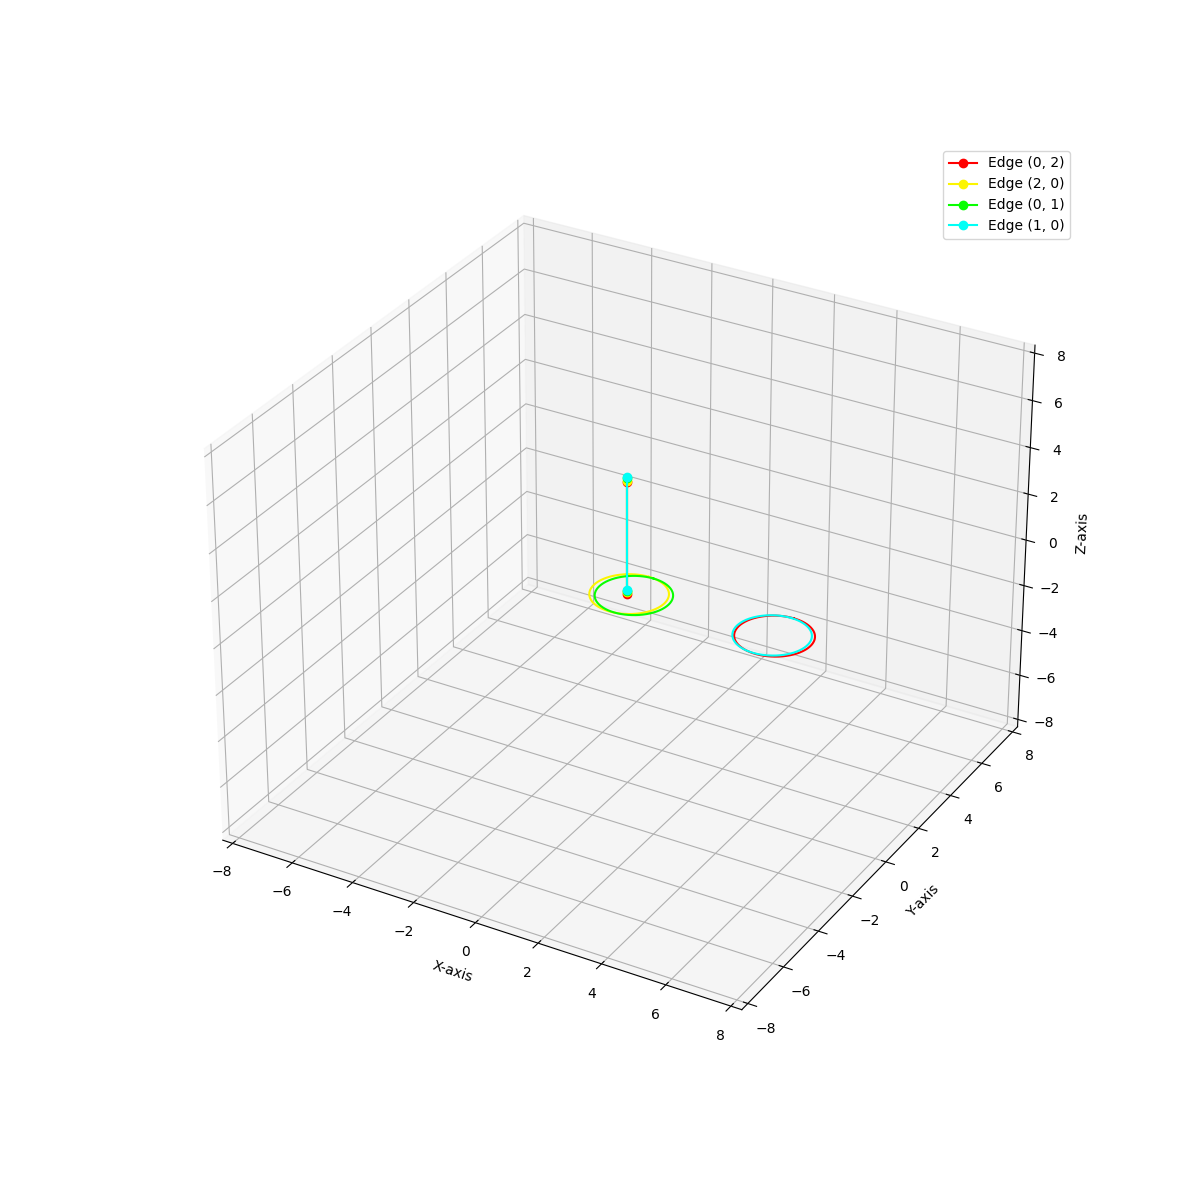

In [26]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.hsv

i = 0
for key, adj in AdjacentDict.items():
    resetNodes(nodeCoords)
    color = colors(i / len(AdjacentDict))
    nodeCoords[adj.theEdge.src.uuid].coord = (0,0,0) 
    nodeCoords[adj.theEdge.dst.uuid].coord = (adj.theEdge.dist, 0, 0)
    
    angle = 0
    rot = 0
    
    plotBaselinePolar(ax, (0,0,0.05*i), rot, angle, adj.theEdge, color)
    # plotBaseline(ax,adj,color)
    plotGonio(ax, (0,0,0), adj, rot, angle, color)

    if i == 3:
        break

    i += 1

# Set axis limits and labels
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_zlim(-8, 8)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.legend()

# Show the 3D plot
plt.gca().set_aspect('auto')
plt.show()

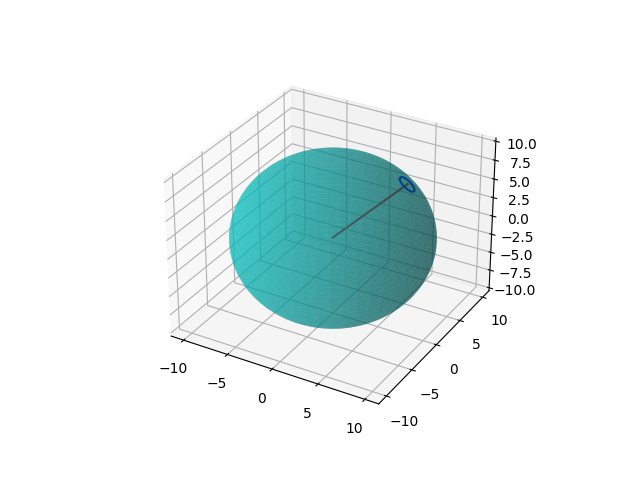

In [27]:
# Specify the user inputs
Rmag = 10  # Sphere radius
radius = 1  # Circle radius


psi = np.deg2rad(30)  # yaw rotation angle
theta = -45 * np.pi / 180  # pitch rotation angle (negative rotation is up)

# Define vectors and Calculate the YAW-PITCH transformation matrix
alpha = np.arcsin(radius / Rmag)

# Planar YAW rotation
YAW = np.array([[np.cos(psi), -np.sin(psi), 0],
                [np.sin(psi), np.cos(psi), 0],
                [0, 0, 1]])  

# Planar PITCH rotation
PITCH = np.array([[np.cos(theta), 0, np.sin(theta)],
                  [0, 1, 0],
                  [-np.sin(theta), 0, np.cos(theta)]])

# YAW-PITCH rotation matrix
YP = np.dot(YAW, PITCH)  # YAW-PITCH rotation matrix

# Rc = Column Vector pointing to the circle on X-Axis (start point)
Rc = np.array([Rmag * np.cos(alpha), 0, radius])
R = np.dot(YP, np.array([Rmag, 0, 0]))  # Vector pointing to the Circle center

# Now sweep the Rc vector around the X-axis to generate the circle
# This is done by adding a planar ROLL rotation to YP
C = np.empty((3, 0))  # C is the vector containing the circle X-Y-Z coordinates
for phi in np.arange(0, 2 * np.pi, np.pi / 50):
    ROLL = np.array([[1, 0, 0],
                     [0, np.cos(phi), -np.sin(phi)],
                     [0, np.sin(phi), np.cos(phi)]])
    YPR = np.dot(YP, ROLL)  # 3-dimensional transform
    Rnew = np.dot(YPR, Rc)
    C = np.append(C, Rnew[:, np.newaxis], axis=1)

# Create a sphere for plotting
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
Sx = Rmag * np.outer(np.cos(u), np.sin(v))
Sy = Rmag * np.outer(np.sin(u), np.sin(v))
Sz = Rmag * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the result
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Sx, Sy, Sz, color='c', alpha=0.5)  # Draw the sphere
ax.plot([0, R[0]], [0, R[1]], [0, R[2]], 'r')  # Vector to Circle center
ax.plot(C[0, :], C[1, :], C[2, :], 'b')  # Circle

# # Plot the original circle on the X-axis (start point) in XY plane
# plot_circle(ax, )

plt.show()


[[1]
 [1]
 [1]]


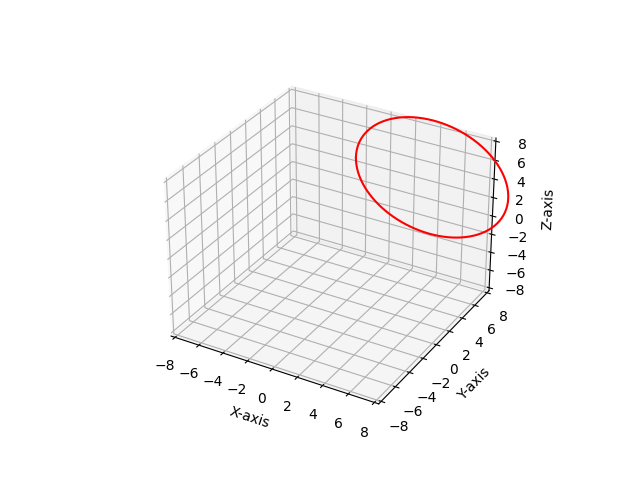

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def draw_circle(ax, r, start_point, orientation_vector, color):
    # # Azimuth angle
    # phi = np.arctan2(orientation_vector[1], orientation_vector[0]) 
    # # Zenith angle
    # theta = np.arctan2(np.sqrt(orientation_vector[0]**2 + orientation_vector[1]**2), orientation_vector[2])

    phi = np.deg2rad(90)
    theta = np.deg2rad(90)
    
    t = np.linspace(0, 2 * np.pi, 201)
    x = start_point[0] - r * (np.cos(t) * np.sin(phi) + np.sin(t) * np.cos(theta) * np.cos(phi))
    y = start_point[1] + r * (np.cos(t) * np.cos(phi) - np.sin(t) * np.cos(theta) * np.sin(phi))
    z = start_point[2] + r * np.sin(t) * np.sin(theta)
    
    ax.plot(x, y, z, color)

# Example usage
start_point = (5,5,5)
r = 6

# R = np.eye(3)
# Specify your own 3x3 rotation matrix here
R = np.array([[1],
              [1],
              [1]])

print(R)

draw_circle(ax, r, start_point, R, 'r')


ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_zlim(-8, 8)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Show the 3D plot
plt.gca().set_aspect('auto')
plt.show()